In [101]:
import numpy as np
import matplotlib as mpl
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

%matplotlib inline
mpl.rcParams['figure.dpi'] = 400

In [102]:
df = pd.read_csv('../Data/df_clean_2.csv')

In [103]:
df.columns.to_list()

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month',
 'EDUCATION_CAT']

For ethical reasons, gender will not be used.

Further, as per our earlier data exploration, PAY_2 through PAY_6 contain faulty data and should also be ignored.

In [104]:
features_response = df.columns.tolist()

In [105]:
features_response

['ID',
 'LIMIT_BAL',
 'SEX',
 'EDUCATION',
 'MARRIAGE',
 'AGE',
 'PAY_1',
 'PAY_2',
 'PAY_3',
 'PAY_4',
 'PAY_5',
 'PAY_6',
 'BILL_AMT1',
 'BILL_AMT2',
 'BILL_AMT3',
 'BILL_AMT4',
 'BILL_AMT5',
 'BILL_AMT6',
 'PAY_AMT1',
 'PAY_AMT2',
 'PAY_AMT3',
 'PAY_AMT4',
 'PAY_AMT5',
 'PAY_AMT6',
 'default payment next month',
 'EDUCATION_CAT']

In [106]:
features_to_remove = ['ID', 'SEX', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'EDUCATION_CAT']

In [107]:
features = [col for col in features_response if col not in features_to_remove]

C:\Users\clgme\AppData\Local\Temp\ipykernel_23648\1740957252.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, center=0)


<AxesSubplot:>

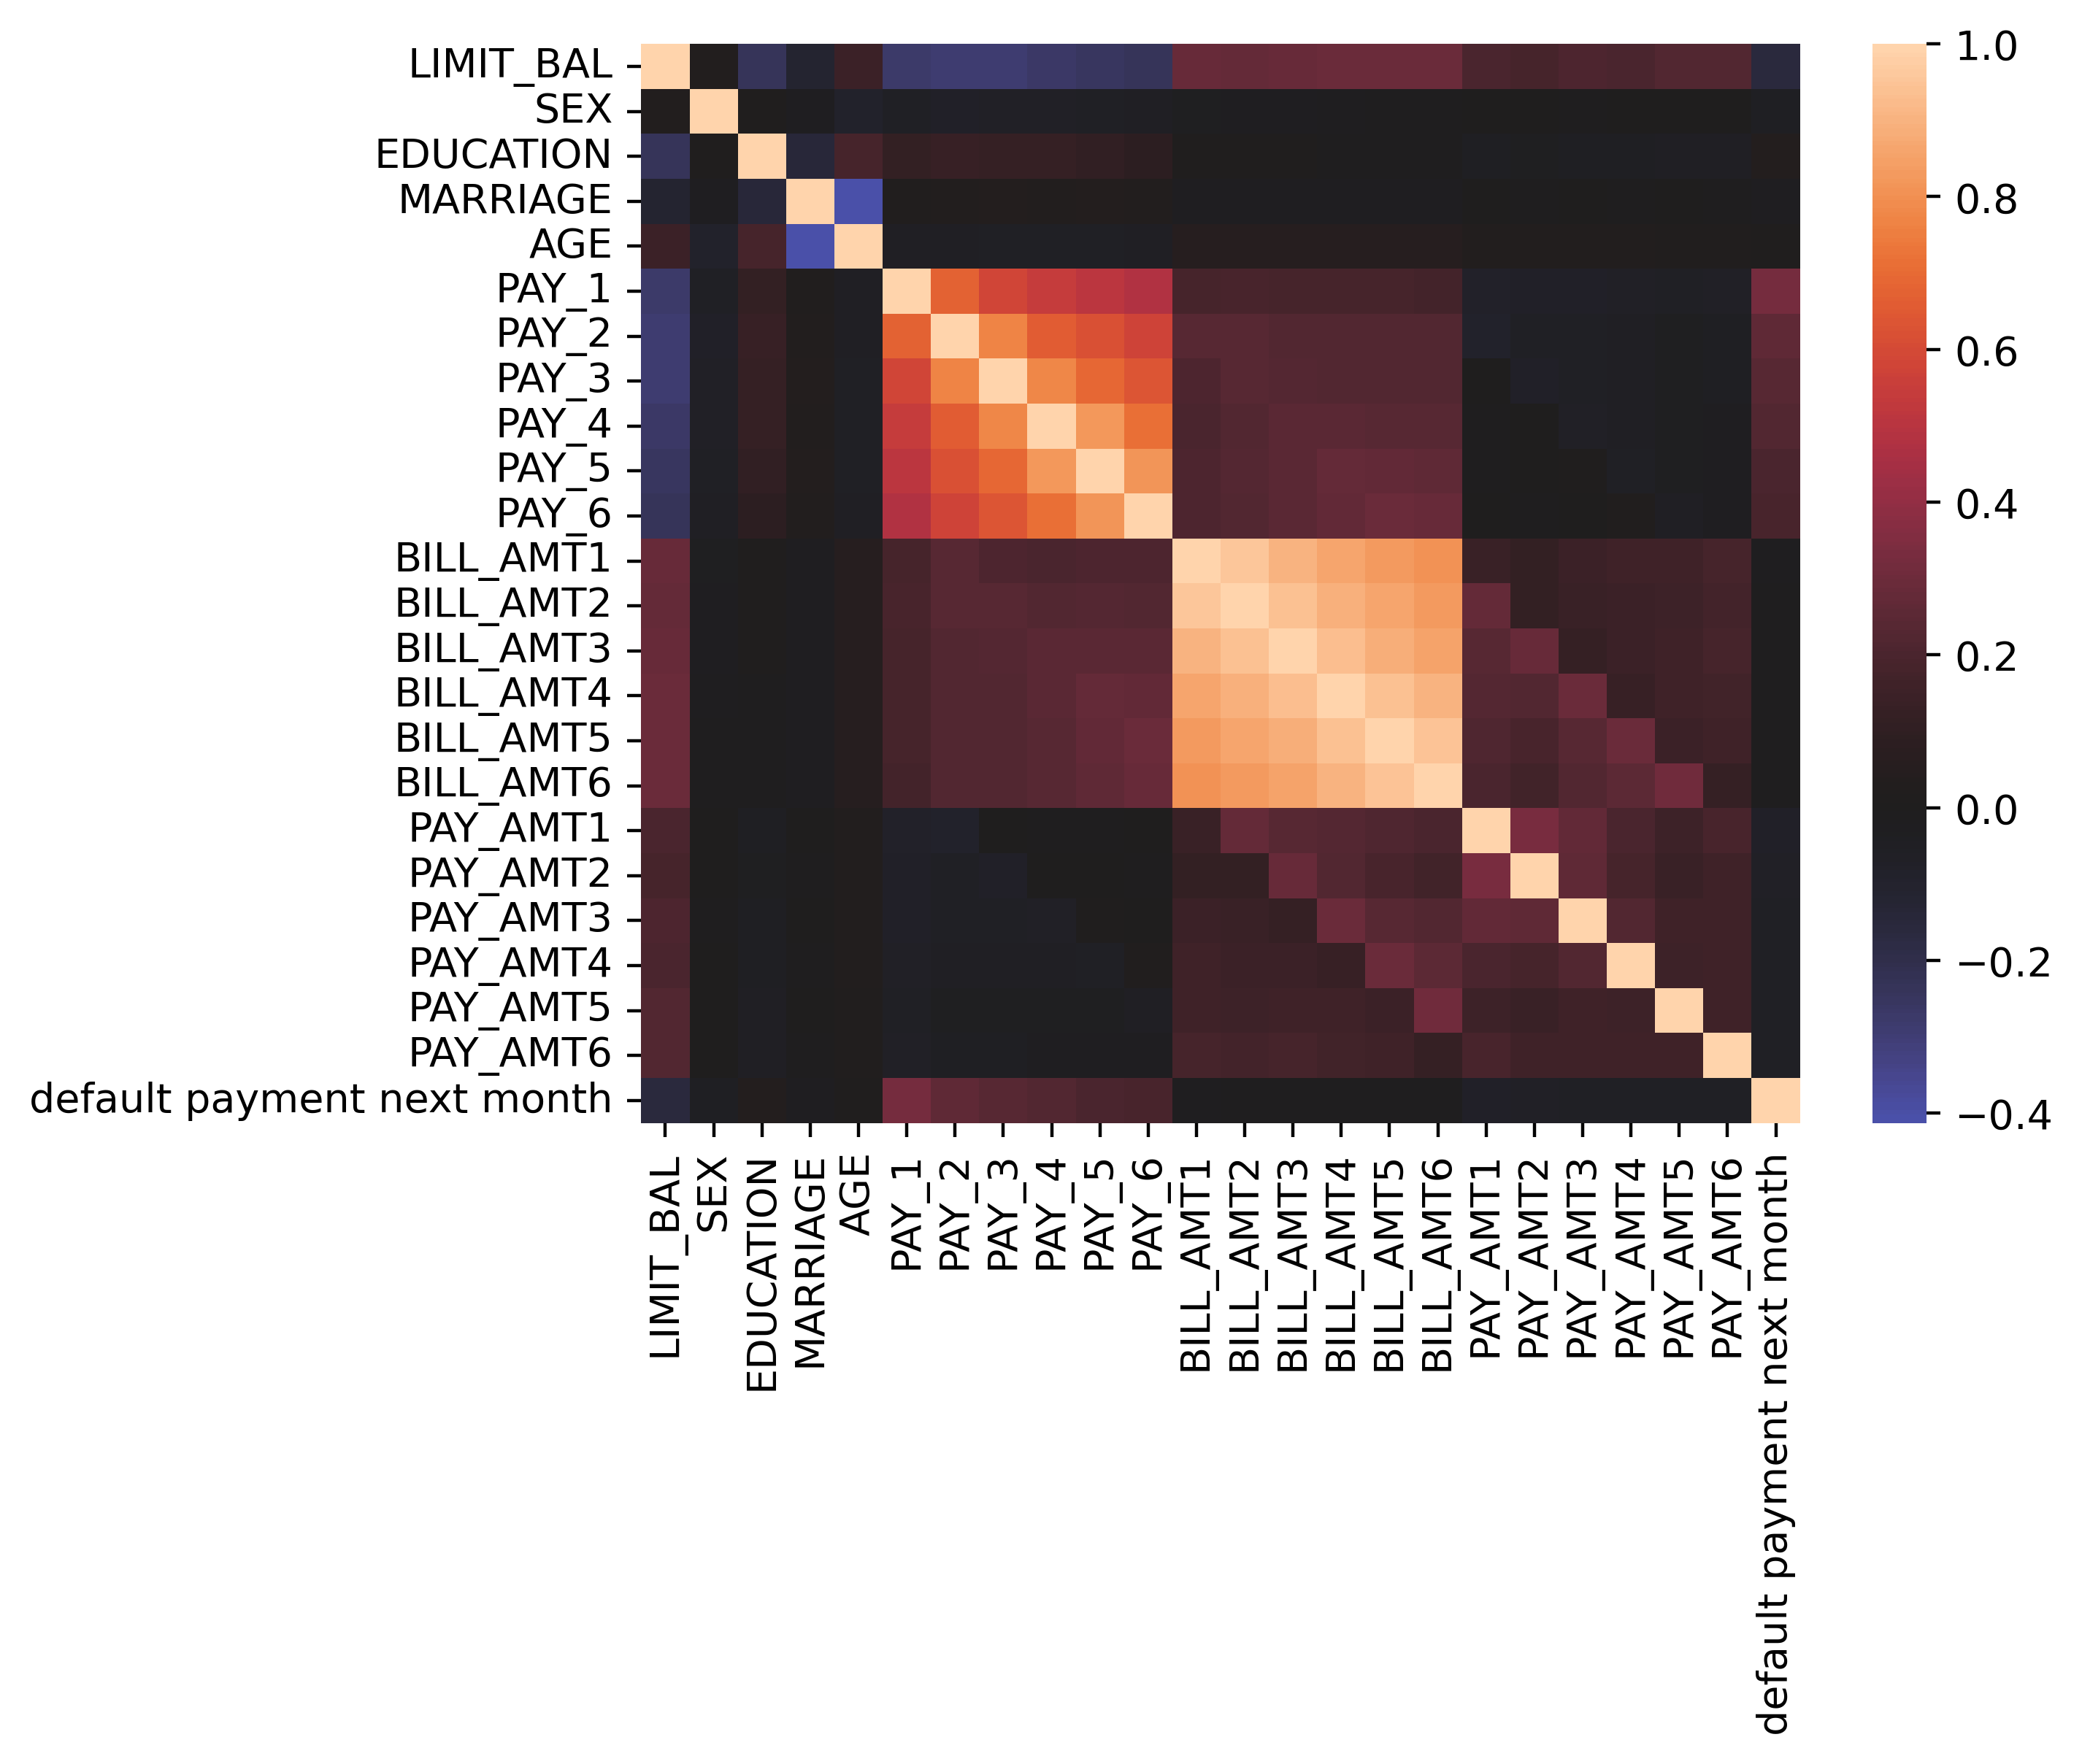

In [108]:
sns.heatmap(df.corr(), xticklabels=df.corr().columns, yticklabels=df.corr().columns, center=0)
# From heatmap, PAY_1 and LIMIT_BAL are the two features with the strongest correlation with response variable default payment next month
# PAY_1 has relatively strong positive correlation with default, whereas LIMIT_BAL has relatively strong negative correlation with default
# PAY_2 - 6 have weak, but still positive correlation with default status

In [109]:
# Pearson correlation above is not 100% approriate for this case study
# This is because data here is binary classification, whereas pearson correlation works best for continuous variables, or regresion
# the usefulness of the above is that it is easy to interpret and glean surface level analysis / information from
# Pearson correlation also only assesses linear relations, which some of the features may or may not have with the response variable

# General examining of feature strength and relation to default payment next month

- F-statistic and p-values

In [110]:
# Because this case study deals with binary classification, can look to use F-statistic / p-values to perform surface level analysis.
# Provides idea of which features would be more important for modeling
X = df[features].iloc[:, :-1]
y = df[features].iloc[:, -1]

In [111]:
[f_stat, f_p_value] = f_classif(X, y)

In [112]:
f_test_df = pd.DataFrame(
    {
        'Feature': features[:-1],
        'F-statistic': f_stat,
        'p value': f_p_value
    }
)

In [113]:
f_test_df.sort_values(by='p value')
# ANOVA F-Test with corresponding p-values is employed here for ranking of feature purposes
# Higher F-statistic and lower p-value indicates that there is a significant difference in the means of the two binary classes for that given feature.
# DataFrame ranking indicates that PAY_1 and LIMIT_BAL are the two features with the greatest significance on the response variable default

# Technically, since this is a binary classification, this would just be a t-test. 
# Further, t-test and F-test assume that the data is normally distributed, which has not been explored yet.
# Additionally, in cases of multi-classification, p-values need to be shifted
# However, for the purpose of ranking the features based on p-value and not performing finalized statistical inferences, this should provide useful surface level analysis

,Feature,F-statistic,p value
4,PAY_1,3156.672300,0.000000e+00
0,LIMIT_BAL,651.324071,5.838366e-142
11,PAY_AMT1,140.612679,2.358354e-32
12,PAY_AMT2,101.408321,8.256124e-24
13,PAY_AMT3,90.023873,2.542641e-21
15,PAY_AMT5,85.843295,2.090120e-20
16,PAY_AMT6,80.420784,3.219565e-19
14,PAY_AMT4,79.640021,4.774112e-19
1,EDUCATION,32.637768,1.122175e-08
2,MARRIAGE,18.078027,2.127555e-05


In [114]:
# To confirm the DataFrame above, use sklearn SelectPercentile to determine the top 20% features
selector = SelectPercentile(f_classif, percentile=20)
selector.fit(X, y)

SelectPercentile(percentile=20)

In [115]:
selector.get_support()

array([ True, False, False, False,  True, False, False, False, False,
       False, False,  True,  True, False, False, False, False])

In [116]:
best_features = X.columns[selector.get_support()]
best_features

Index(['LIMIT_BAL', 'PAY_1', 'PAY_AMT1', 'PAY_AMT2'], dtype='object')

# Visualizing Relationship Between Features & Response Variable

First, exploring PAY_1 feature. How do the default rates change based on the value of this encoded feature?

Because feature is encoded, creating a plot of default rate for each unique coded value in PAY_1 relative to an average would help visualize any trends

In [117]:
# Plotting default rates of the different 
overall_default_rate = df['default payment next month'].mean()
group_by_pay_mean_y = df.groupby(by='PAY_1').agg({'default payment next month': np.mean})

In [118]:
group_by_pay_mean_y

,default payment next month
PAY_1,
-2,0.131664
-1,0.170002
0,0.128295
1,0.336400
2,0.694701
3,0.773973
4,0.682540
5,0.434783
6,0.545455


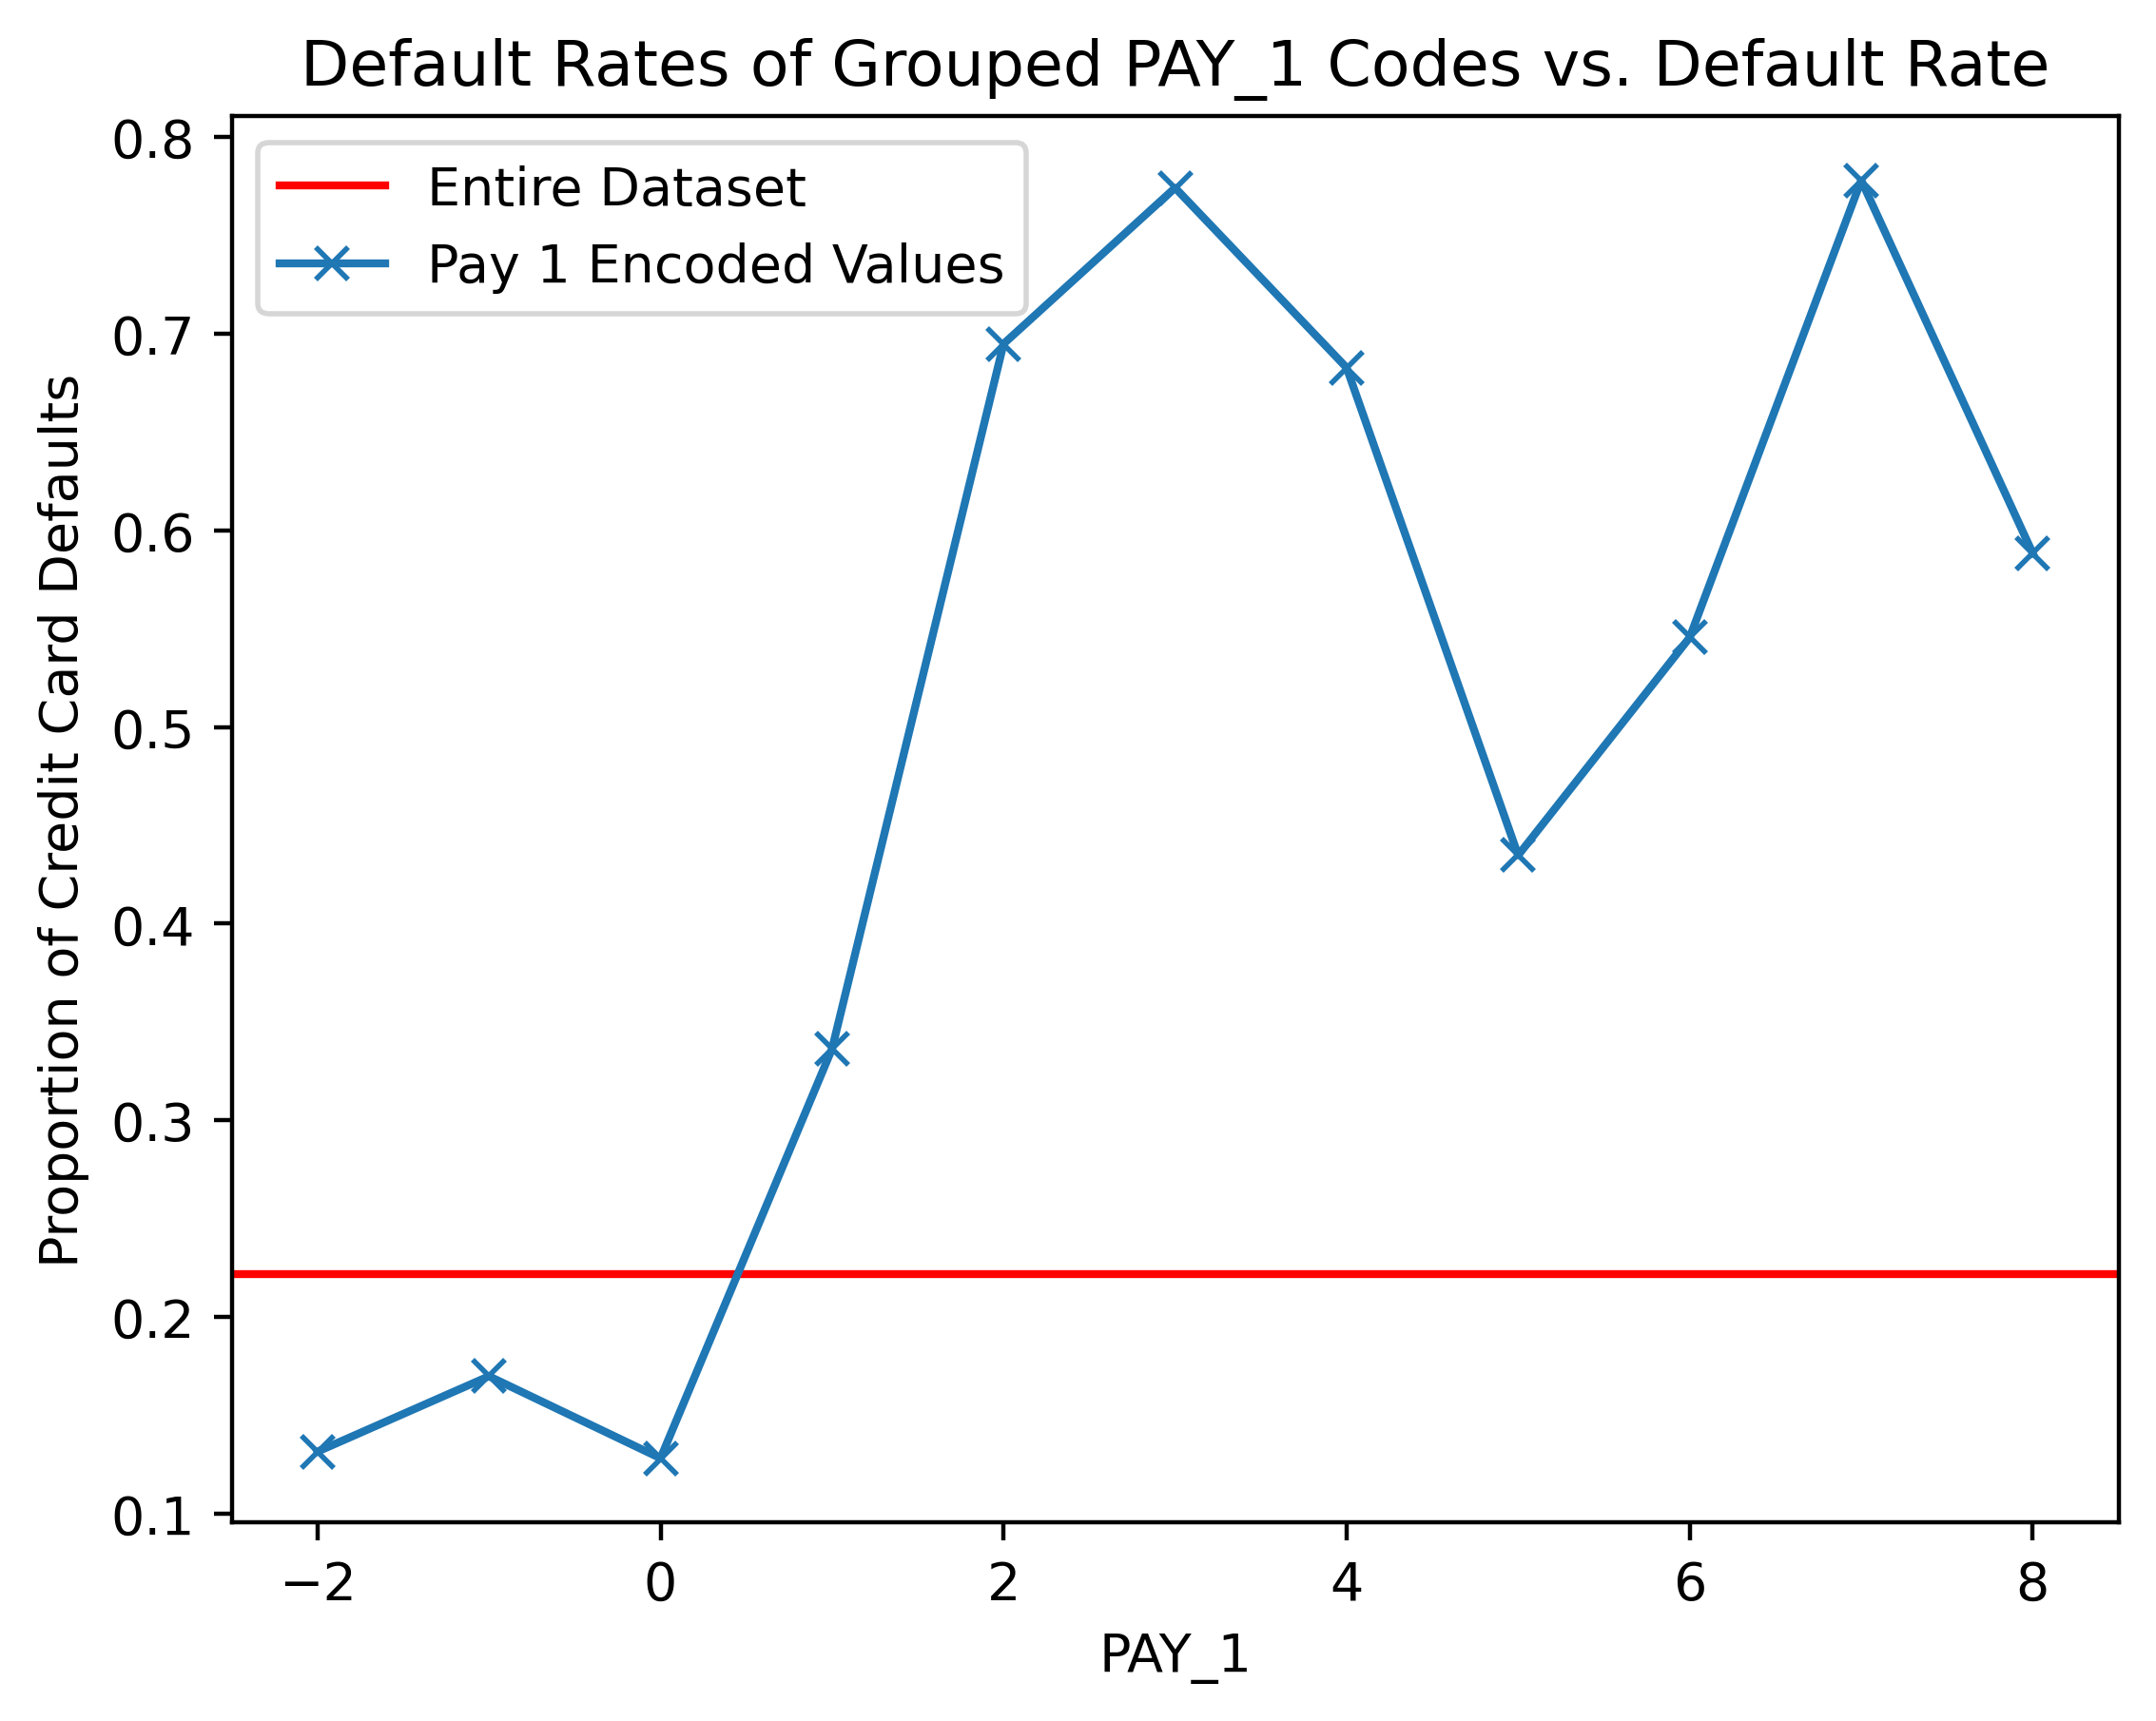

In [119]:
axes = plt.axes()
axes.axhline(overall_default_rate, color='red')
group_by_pay_mean_y.plot(marker='x', legend=False, ax=axes)
axes.set_ylabel('Proportion of Credit Card Defaults')
axes.set_title('Default Rates of Grouped PAY_1 Codes vs. Default Rate')
axes.legend(['Entire Dataset', 'Pay 1 Encoded Values'])

# From visual, it is apparent that default rates tend to climb as delinquency in payment increases. Accounts that have at least paid the monthly minimum or have paid their monthly fees duly exhibit lower default rates.
# Compared to the average default rate of the entire dataset, accounts in good standing are lower than the average default rate of the entire dataset, whereas accounts with delinquent payment statuses exhibit higher than average default rates. This means accounts that are default in this month are more likely to be in default in the next month

Exploring Limit Balance Relation to Default Rate

In this case, limit balance is a continuous variable and is not encoded like PAY_1. To visualize continuous variable values in relation to default statis (encoded response variable), can plot layered histograms to compare values between binary classes

Text(0.5, 1.0, 'Credit Limits vs Defaults')

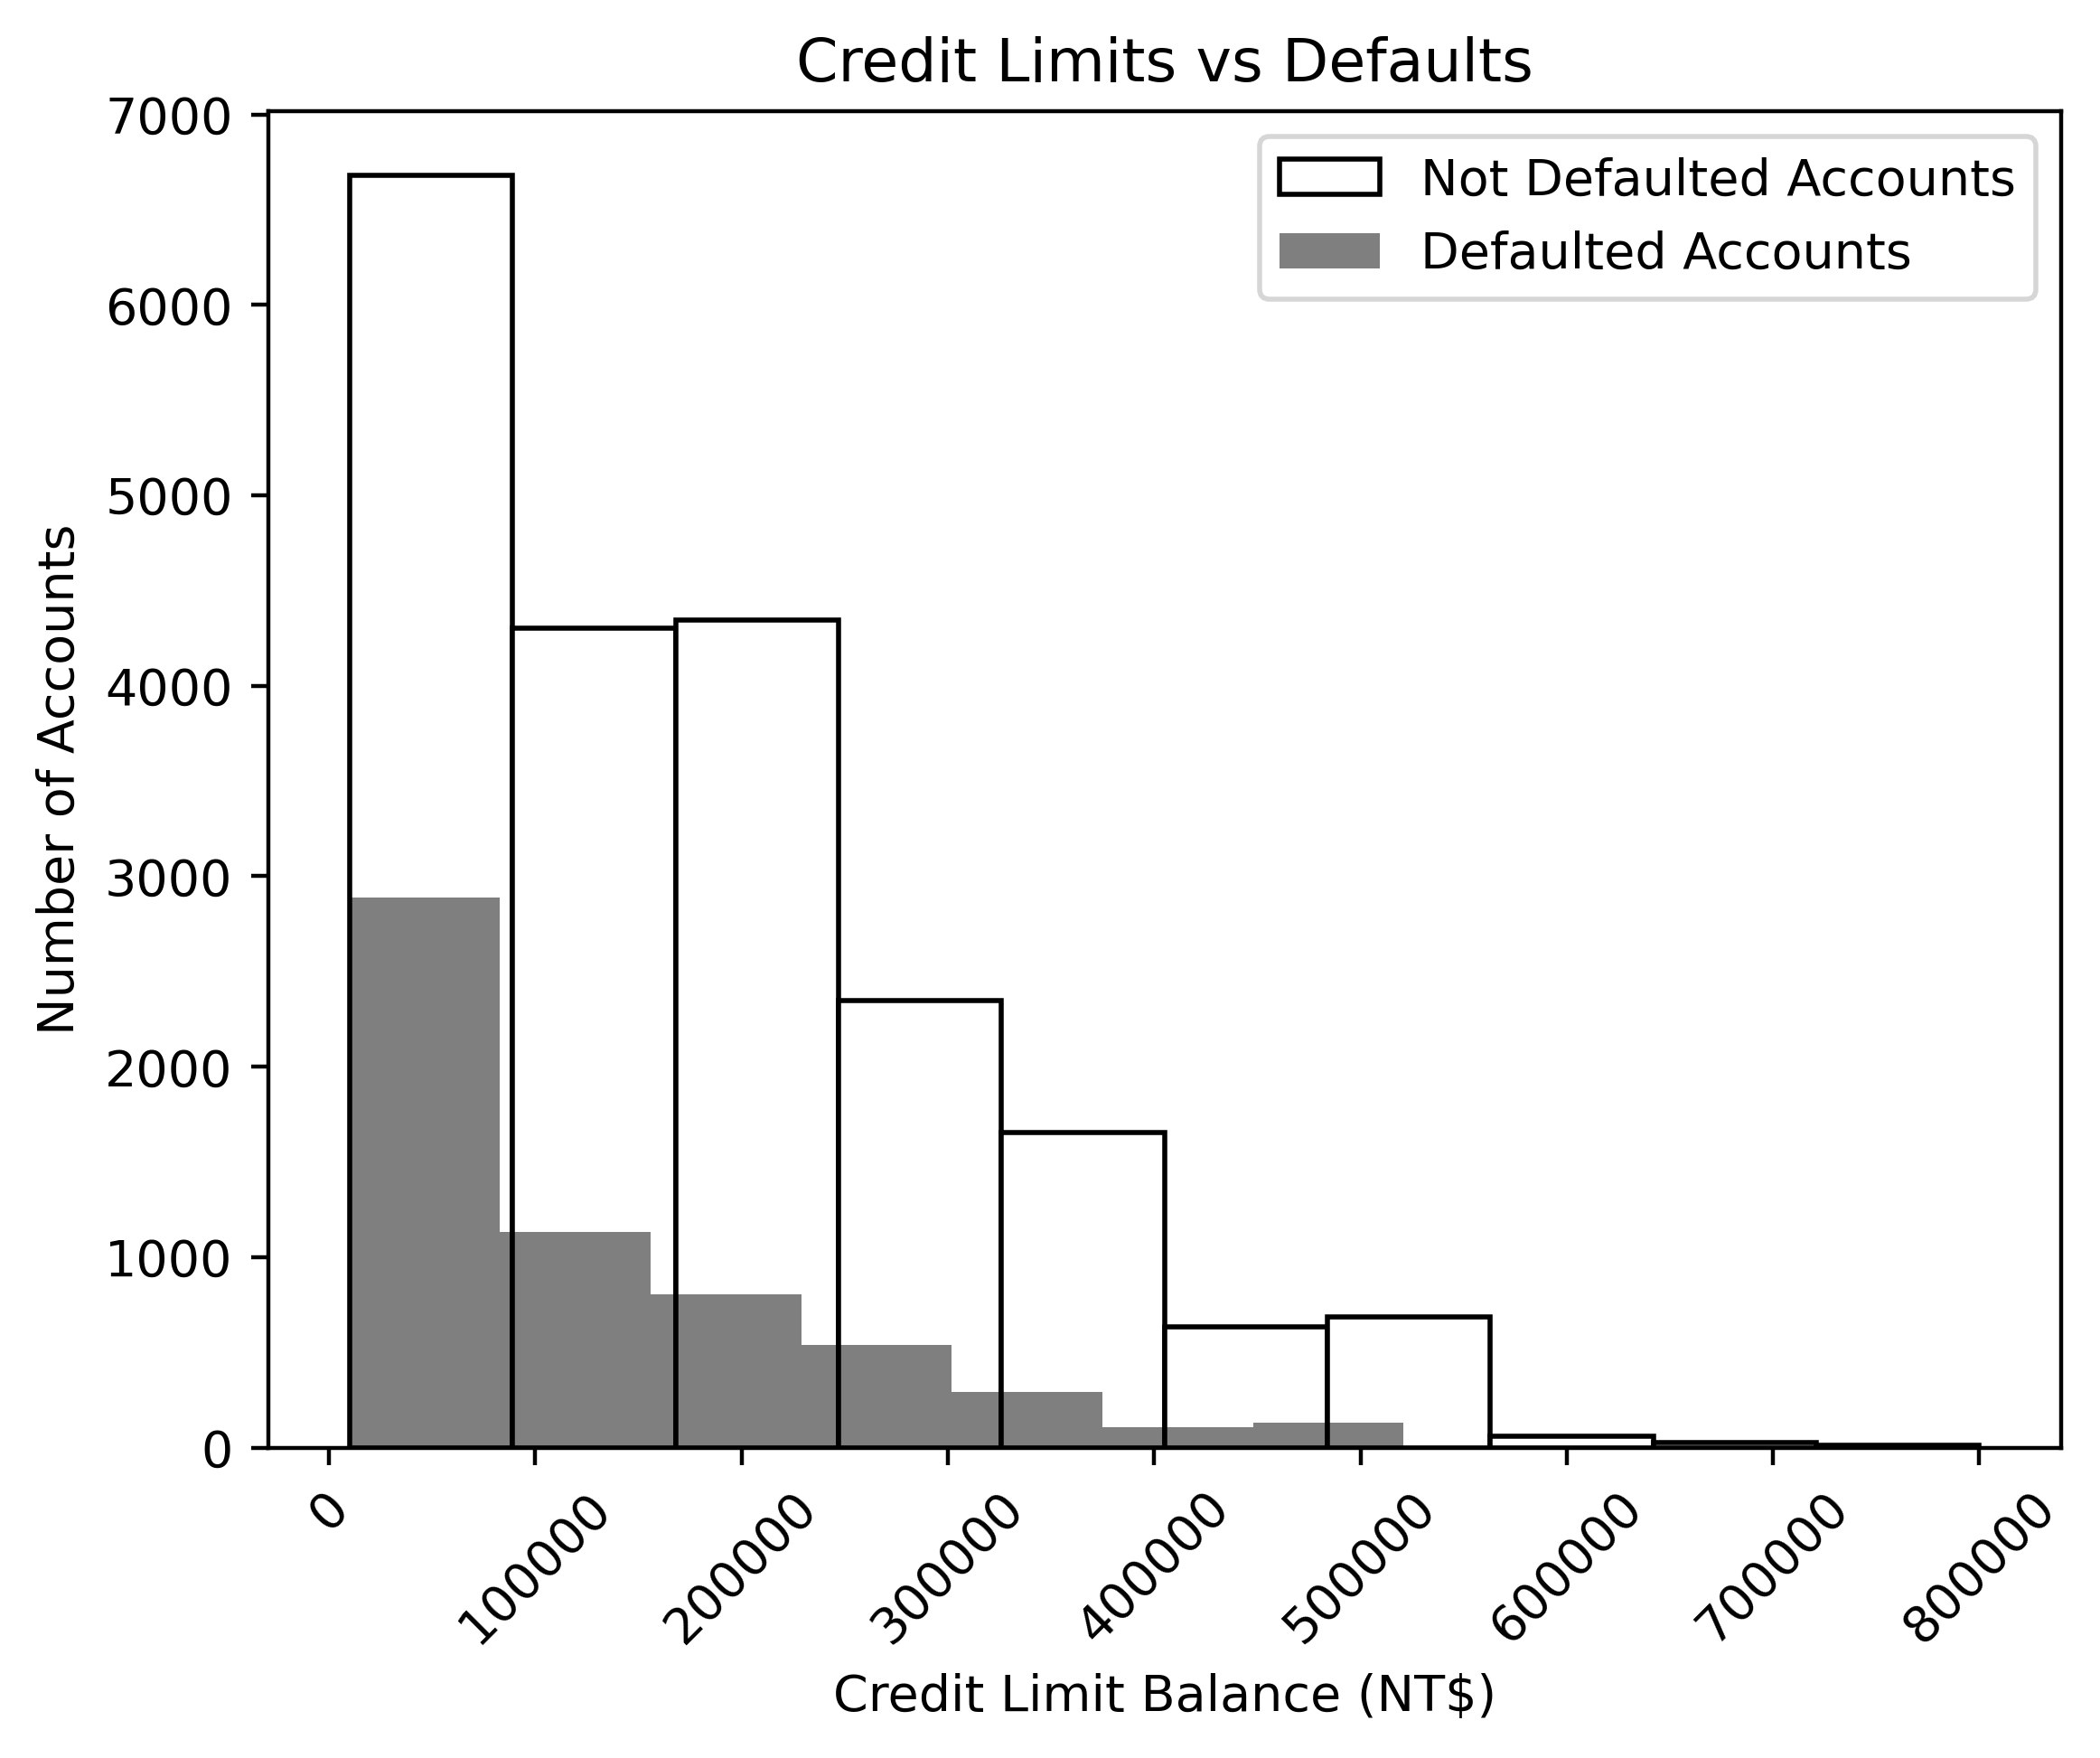

In [120]:
pos_mask = y == 1
neg_mask = y == 0

axes = plt.axes()
axes.hist(x=df.loc[neg_mask, 'LIMIT_BAL'], color='white', edgecolor='black')
axes.hist(x=df.loc[pos_mask, 'LIMIT_BAL'], alpha=0.5, color='black', edgecolor=None)
axes.tick_params(axis='x', labelrotation=45)
axes.set_xlabel('Credit Limit Balance (NT$)')
axes.set_ylabel('Number of Accounts')
axes.legend(['Not Defaulted Accounts', 'Defaulted Accounts'])
axes.set_title('Credit Limits vs Defaults')

In [121]:
# The above visual helps examine the relation of limit balance with defaults. However, it is not entirely useful because there's a large discrepancy in the number of accounts that have not defaulted versus the number of accounts that have defaulted. All this tells us is the size/counts of the histograms and not the shape of the histograms.

# One solution can be normalizing the data, which makes the area of the two histograms the same. Using probability mass functions, we can ensure that the itegral of the histograms will be equal to 1 after normalization. This makes sense logically because probabilities, in total, sum to 1.

In [122]:
bin_edges = list(range(0, max(df['LIMIT_BAL']) + 50000, 50000))

In [123]:
print(bin_edges)

[0, 50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000, 550000, 600000, 650000, 700000, 750000, 800000]


C:\Users\clgme\AppData\Local\Temp\ipykernel_23648\978076064.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_yticklabels(np.round(y_ticks * 50000, 2))


Text(0.5, 1.0, 'Normalized distributions of credit limits by response variable')

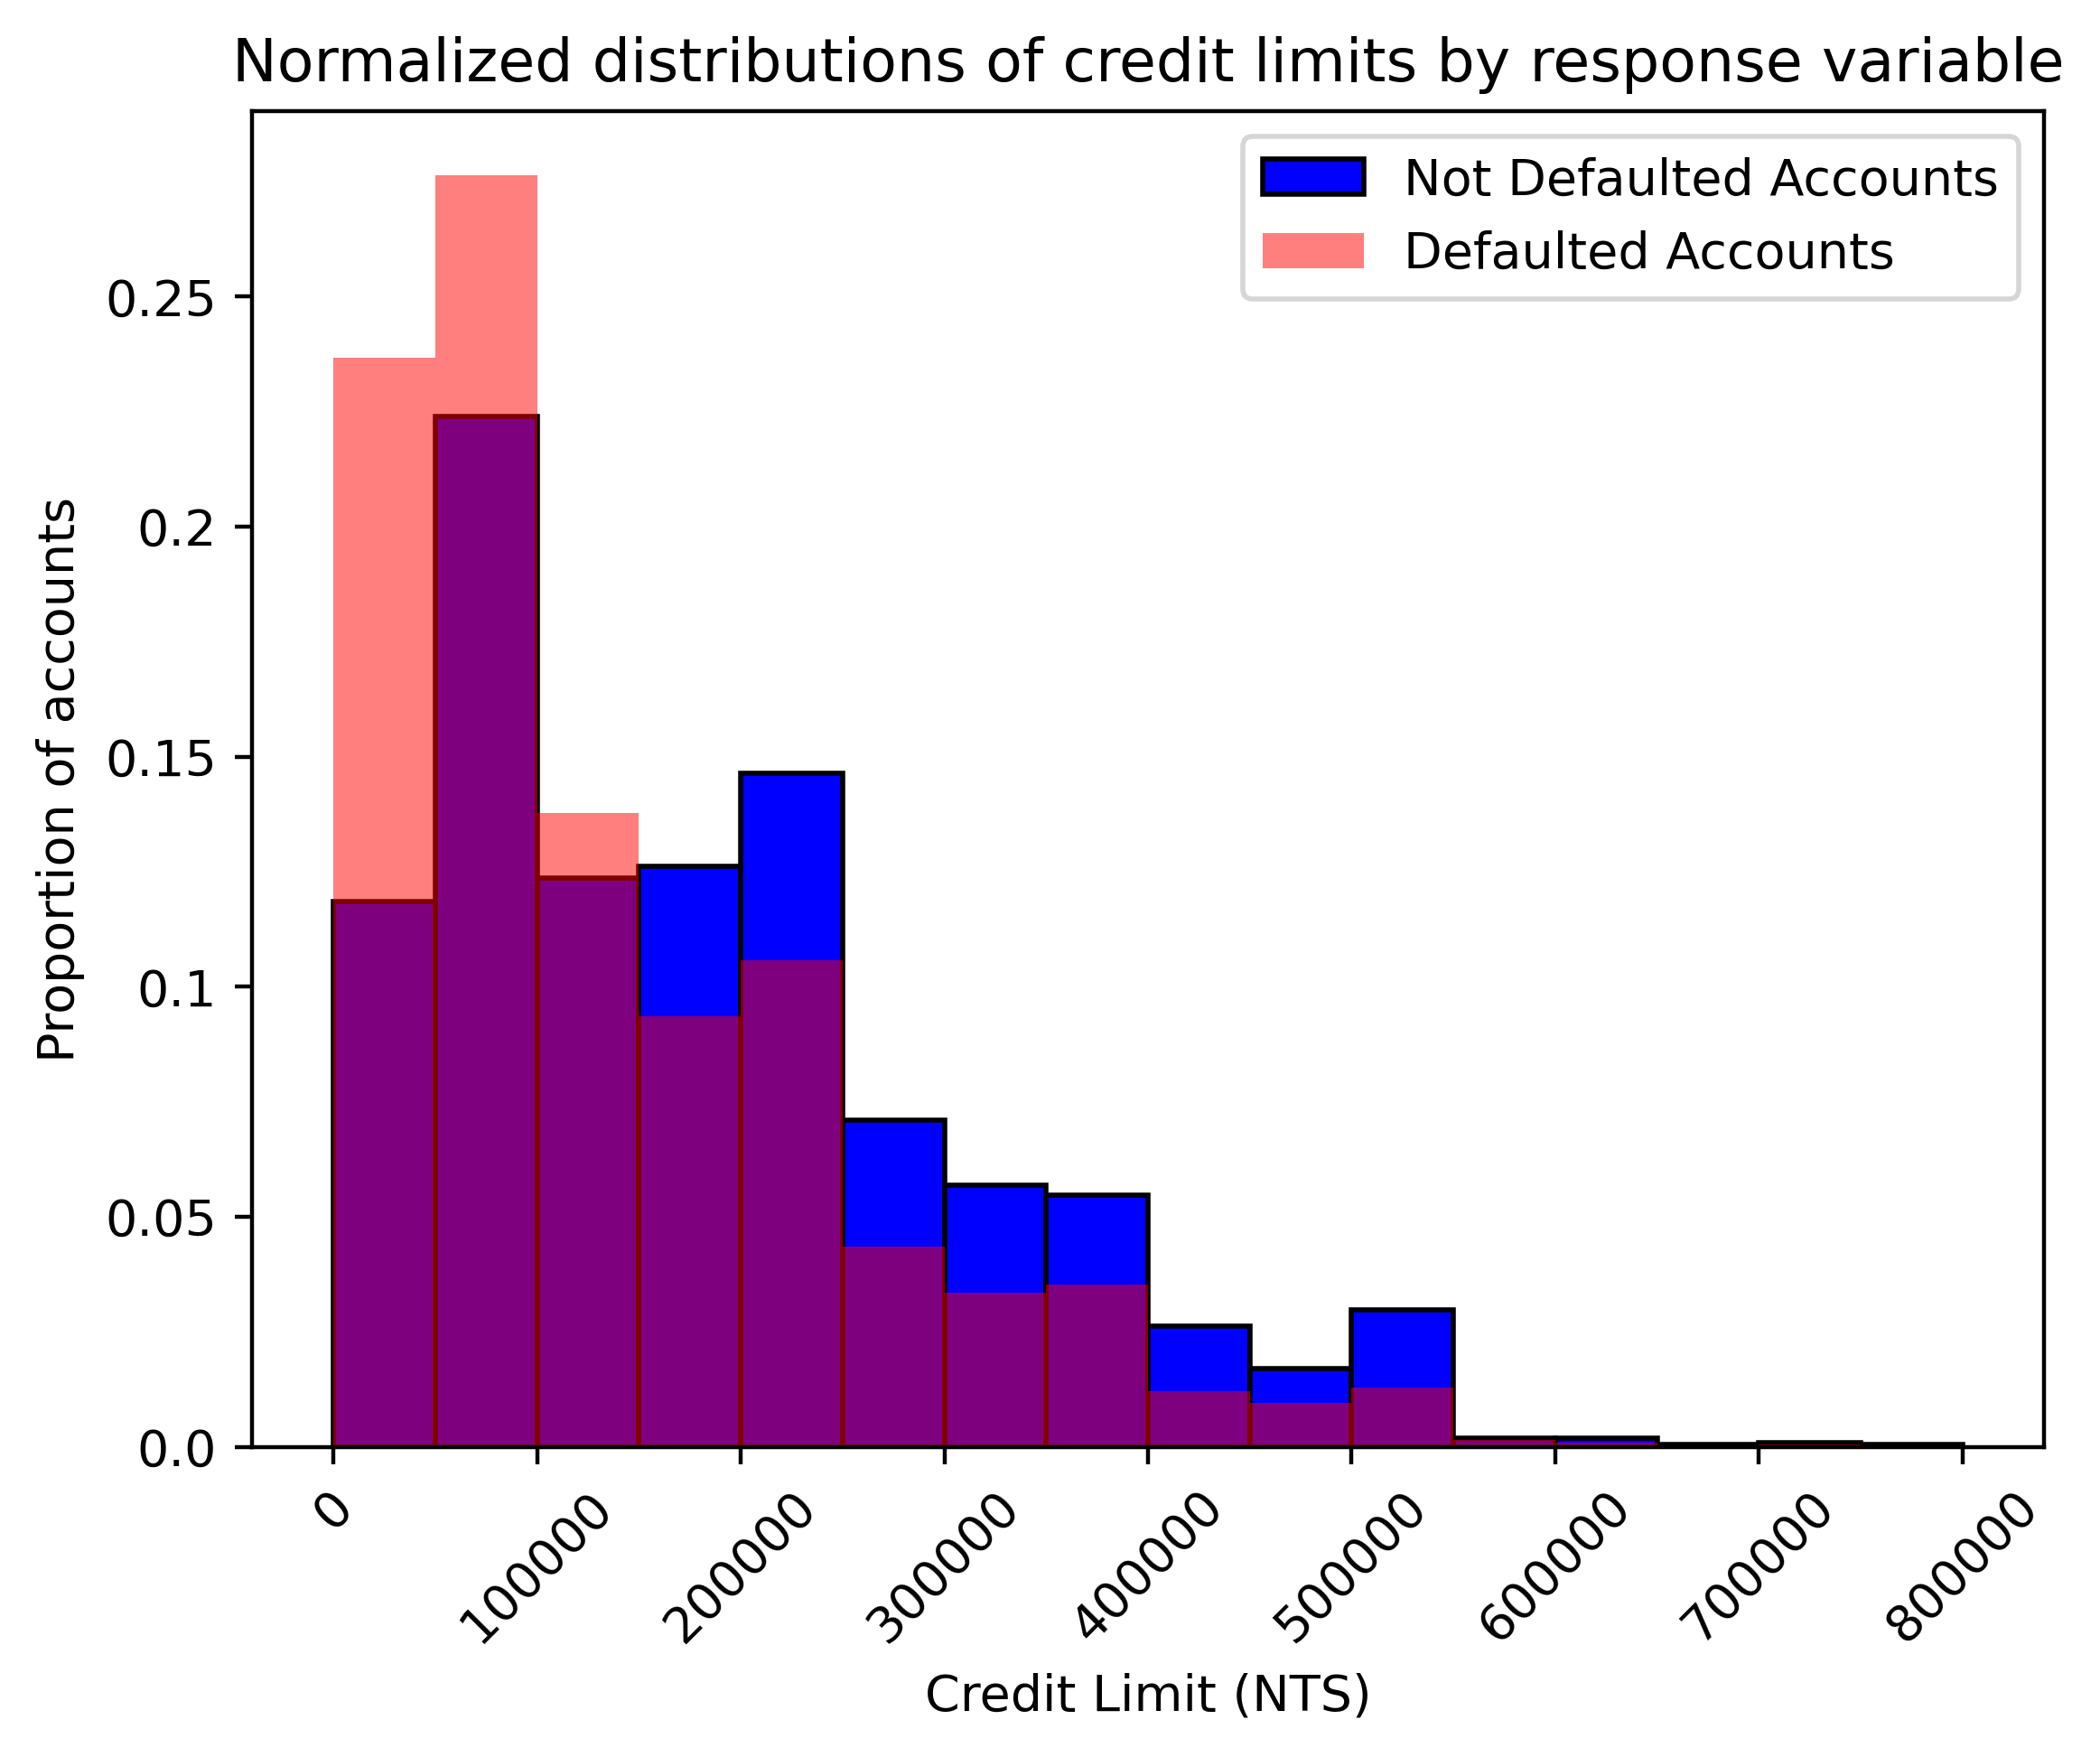

In [124]:
axes = plt.axes()
axes.hist(x=df.loc[neg_mask, 'LIMIT_BAL'], bins=bin_edges, density=True, color='blue', edgecolor='black')
axes.hist(x=df.loc[pos_mask, 'LIMIT_BAL'], bins=bin_edges, density=True, color='red', alpha=0.5)
axes.tick_params(axis='x', labelrotation=45)
y_ticks = axes.get_yticks()
axes.set_yticklabels(np.round(y_ticks * 50000, 2))
axes.legend(['Not Defaulted Accounts', 'Defaulted Accounts'])
axes.set_ylabel('Proportion of accounts')
axes.set_xlabel('Credit Limit (NTS)')
axes.set_title('Normalized distributions of credit limits by response variable')

In [125]:
# From the normalized distribution, it is apparent that accounts with lower credit limits exhibit higher proportions of defaulting vs. accounts with higher credit limits that have higher proportions of not defaulting.

In [126]:
# To reiterate, the above methods of data examination are just to get a quick idea of the relationship of features with the response variable
# There are statistical assumptions that methods such as T-test and p-value examination that must be explored before performing statistical inferences. The above methods are just surface level analysis of features. 
# Another aspect of the data we can look at is if a feature like PAY_1 is linear with log odds (log(p/q/) = linear combination of input features; as derived from logistic regression)

# Examining Appropriateness of Logistic Regression

Text(0.5, 0, 'Values of PAY_1')

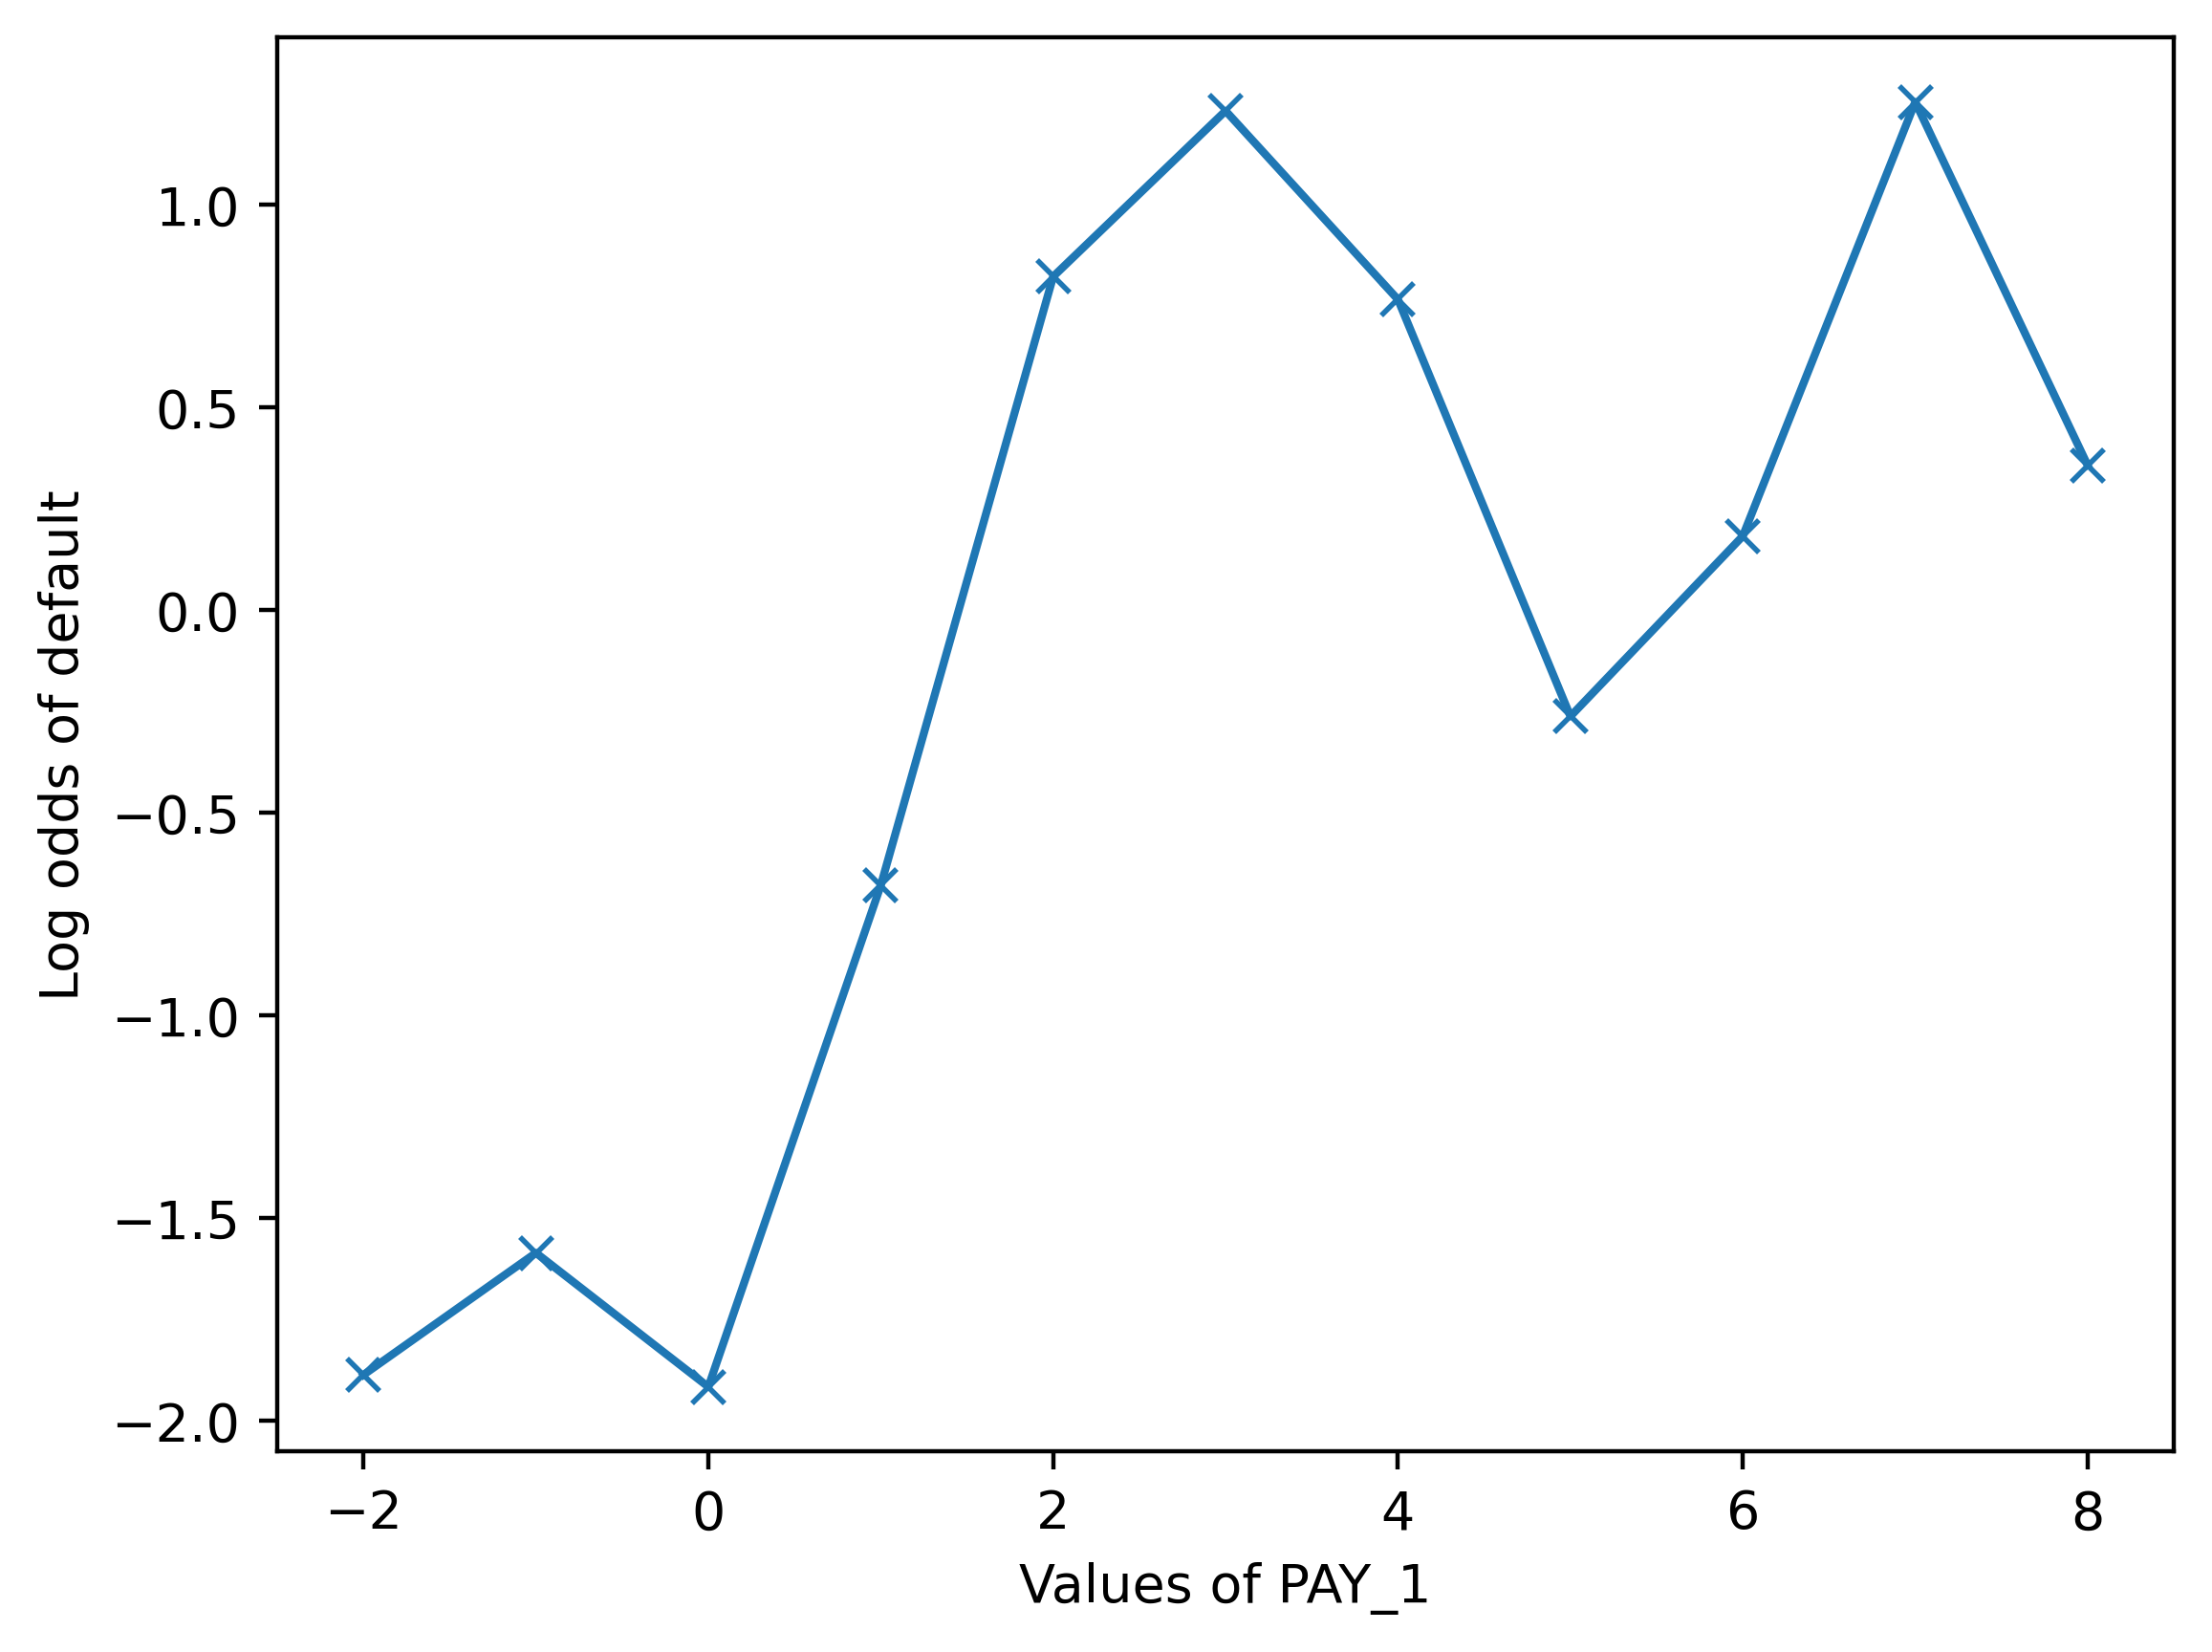

In [127]:
# In logistic regression, 'p' represents the probability the sample is positive (1), and 'q' represents 1 - p, or the probability that the sample is negative.
p = group_by_pay_mean_y
q = 1 - p
odds_ratio = p / q
log_odds = np.log(odds_ratio)
plt.plot(group_by_pay_mean_y.index, log_odds, '-x')
plt.ylabel('Log odds of default')
plt.xlabel('Values of PAY_1')
# From the plot below, there is a linear trend as the value of PAY_1 progresses sequentially. This means that the data may be appropriate for logistic regression.  
# Perhaps some data transformations or even a different means of encoding -2, -1, and 0 would help with modeling.

# Cross Validation & Feature Engineering

In [128]:
sum(df['default payment next month'] == 1)

5914

In [129]:
# Following rule of 10, for less observed class (positive default, or 1 coding) there are 5914 samples. A rule of 10 would suggest 50 or so features, whereas the data we have trimmed down because of business understandings and data source issues contains 17 features. 

In [130]:
X_train, X_test, y_train, y_test = train_test_split(df[features[:-1]].values, df[features[-1]].values, test_size=0.20, random_state=24)

In [131]:
print('X Train Shape: {} \nX_test.shape: {}'.format(X_train.shape, X_test.shape))

X Train Shape: (21331, 17) 
X_test.shape: (5333, 17)


In [132]:
print('y Train Shape: {} \ny_test.shape: {}'.format(y_train.shape, y_test.shape))

y Train Shape: (21331,) 
y_test.shape: (5333,)


In [133]:
min_max_sc = MinMaxScaler()

In [134]:
lr = LogisticRegression(penalty='l1', solver='saga', max_iter=1000)  # Setting iterations for gradient descent, under the hood parameter convergence

In [135]:
scale_lr_pipeline = Pipeline(
    steps = [
        ('scaler', min_max_sc),
        ('model', lr)
    ]
)

In [136]:
scale_lr_pipeline.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('model', LogisticRegression(max_iter=1000, penalty='l1', solver='saga'))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'model': LogisticRegression(max_iter=1000, penalty='l1', solver='saga'),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'model__C': 1.0,
 'model__class_weight': None,
 'model__dual': False,
 'model__fit_intercept': True,
 'model__intercept_scaling': 1,
 'model__l1_ratio': None,
 'model__max_iter': 1000,
 'model__multi_class': 'auto',
 'model__n_jobs': None,
 'model__penalty': 'l1',
 'model__random_state': None,
 'model__solver': 'saga',
 'model__tol': 0.0001,
 'model__verbose': 0,
 'model__warm_start': False}

In [137]:
scale_lr_pipeline.get_params()['model__C']

1.0

In [138]:
scale_lr_pipeline.set_params(model__C=2)
# Recall C controls the weight of prediction errors on parameter tuning of logistic regression log odds
# Above is an example of how to change parameter of pipeline model

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('model',
                 LogisticRegression(C=2, max_iter=1000, penalty='l1',
                                    solver='saga'))])

In [139]:
C_val_exponents = np.linspace(2, -3, 6)
C_vals = np.float(10)**C_val_exponents  # Generating list of C parameter values for CV

C:\Users\clgme\AppData\Local\Temp\ipykernel_23648\1170409680.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  C_vals = np.float(10)**C_val_exponents  # Generating list of C parameter values for CV


In [140]:
k_folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=1)

In [141]:
def cross_val_C_search_pipe(k_folds, C_vals, pipeline, X, Y):
    '''
    Performs k-fold cross-validation for various C values for a given pipeline model. Returns ROC AUC scores and ROC TPR, FPR, and threshold values for each fold iteration for each C value.
    '''
    n_folds = k_folds.n_splits
    # Create empty lists for storing scores
    cv_train_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc_auc = np.empty((n_folds, len(C_vals)))
    cv_test_roc = [[]] * len(C_vals)
    #Begin looping through C-values for lr model
    for c_val_counter in range(len(C_vals)):
        pipeline.set_params(model__C=C_vals[c_val_counter])  # Set C value for pipeline
        fold_counter = 0  # Establishing index counter for current fold
        for train_index, test_index in k_folds.split(X, Y):
            # Set train and test sets for current fold
            X_cv_train, X_cv_test = X[train_index], X[test_index]
            y_cv_train, y_cv_test = Y[train_index], Y[test_index]
            # Fit model to train
            pipeline.fit(X_cv_train, y_cv_train)
            # Acquire ROC AUC scores for train (used for over/under fitting evaluation)
            cv_train_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_train, pipeline.predict_proba(X_cv_train)[:, 1])
            # Acquire ROC AUC scores for test 
            cv_test_roc_auc[fold_counter, c_val_counter] = roc_auc_score(y_cv_test, pipeline.predict_proba(X_cv_test)[:, 1])
            # Acquire ROC curves for each fold. Array is built different for selecting best possible C-value based on CV scores and then plotting FPR vs TPR to establish performance with varying thresholds
            cv_test_roc[c_val_counter].append(roc_curve(y_cv_test, pipeline.predict_proba(X_cv_test)[:, 1]))
            # Iterate fold index tracker
            fold_counter += 1
        # Progress tracking
        print('Done with C = {}'.format(C_vals[c_val_counter]))

    return cv_train_roc_auc, cv_test_roc_auc, cv_test_roc

In [142]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds=k_folds, C_vals=C_vals, pipeline=scale_lr_pipeline, X=X_train, Y=y_train)

Done with C = 100.0
Done with C = 10.0
Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


In [143]:
np.mean(cv_train_roc_auc, axis=0)

array([0.71987412, 0.71967568, 0.71801248, 0.71543169, 0.71644945,
       0.5       ])

In [144]:
np.mean(cv_test_roc_auc, axis=0)


array([0.71874796, 0.71857014, 0.7169684 , 0.71511052, 0.7164791 ,
       0.5       ])

Text(0.5, 1.0, 'Cross Validation Train/Test Scores')

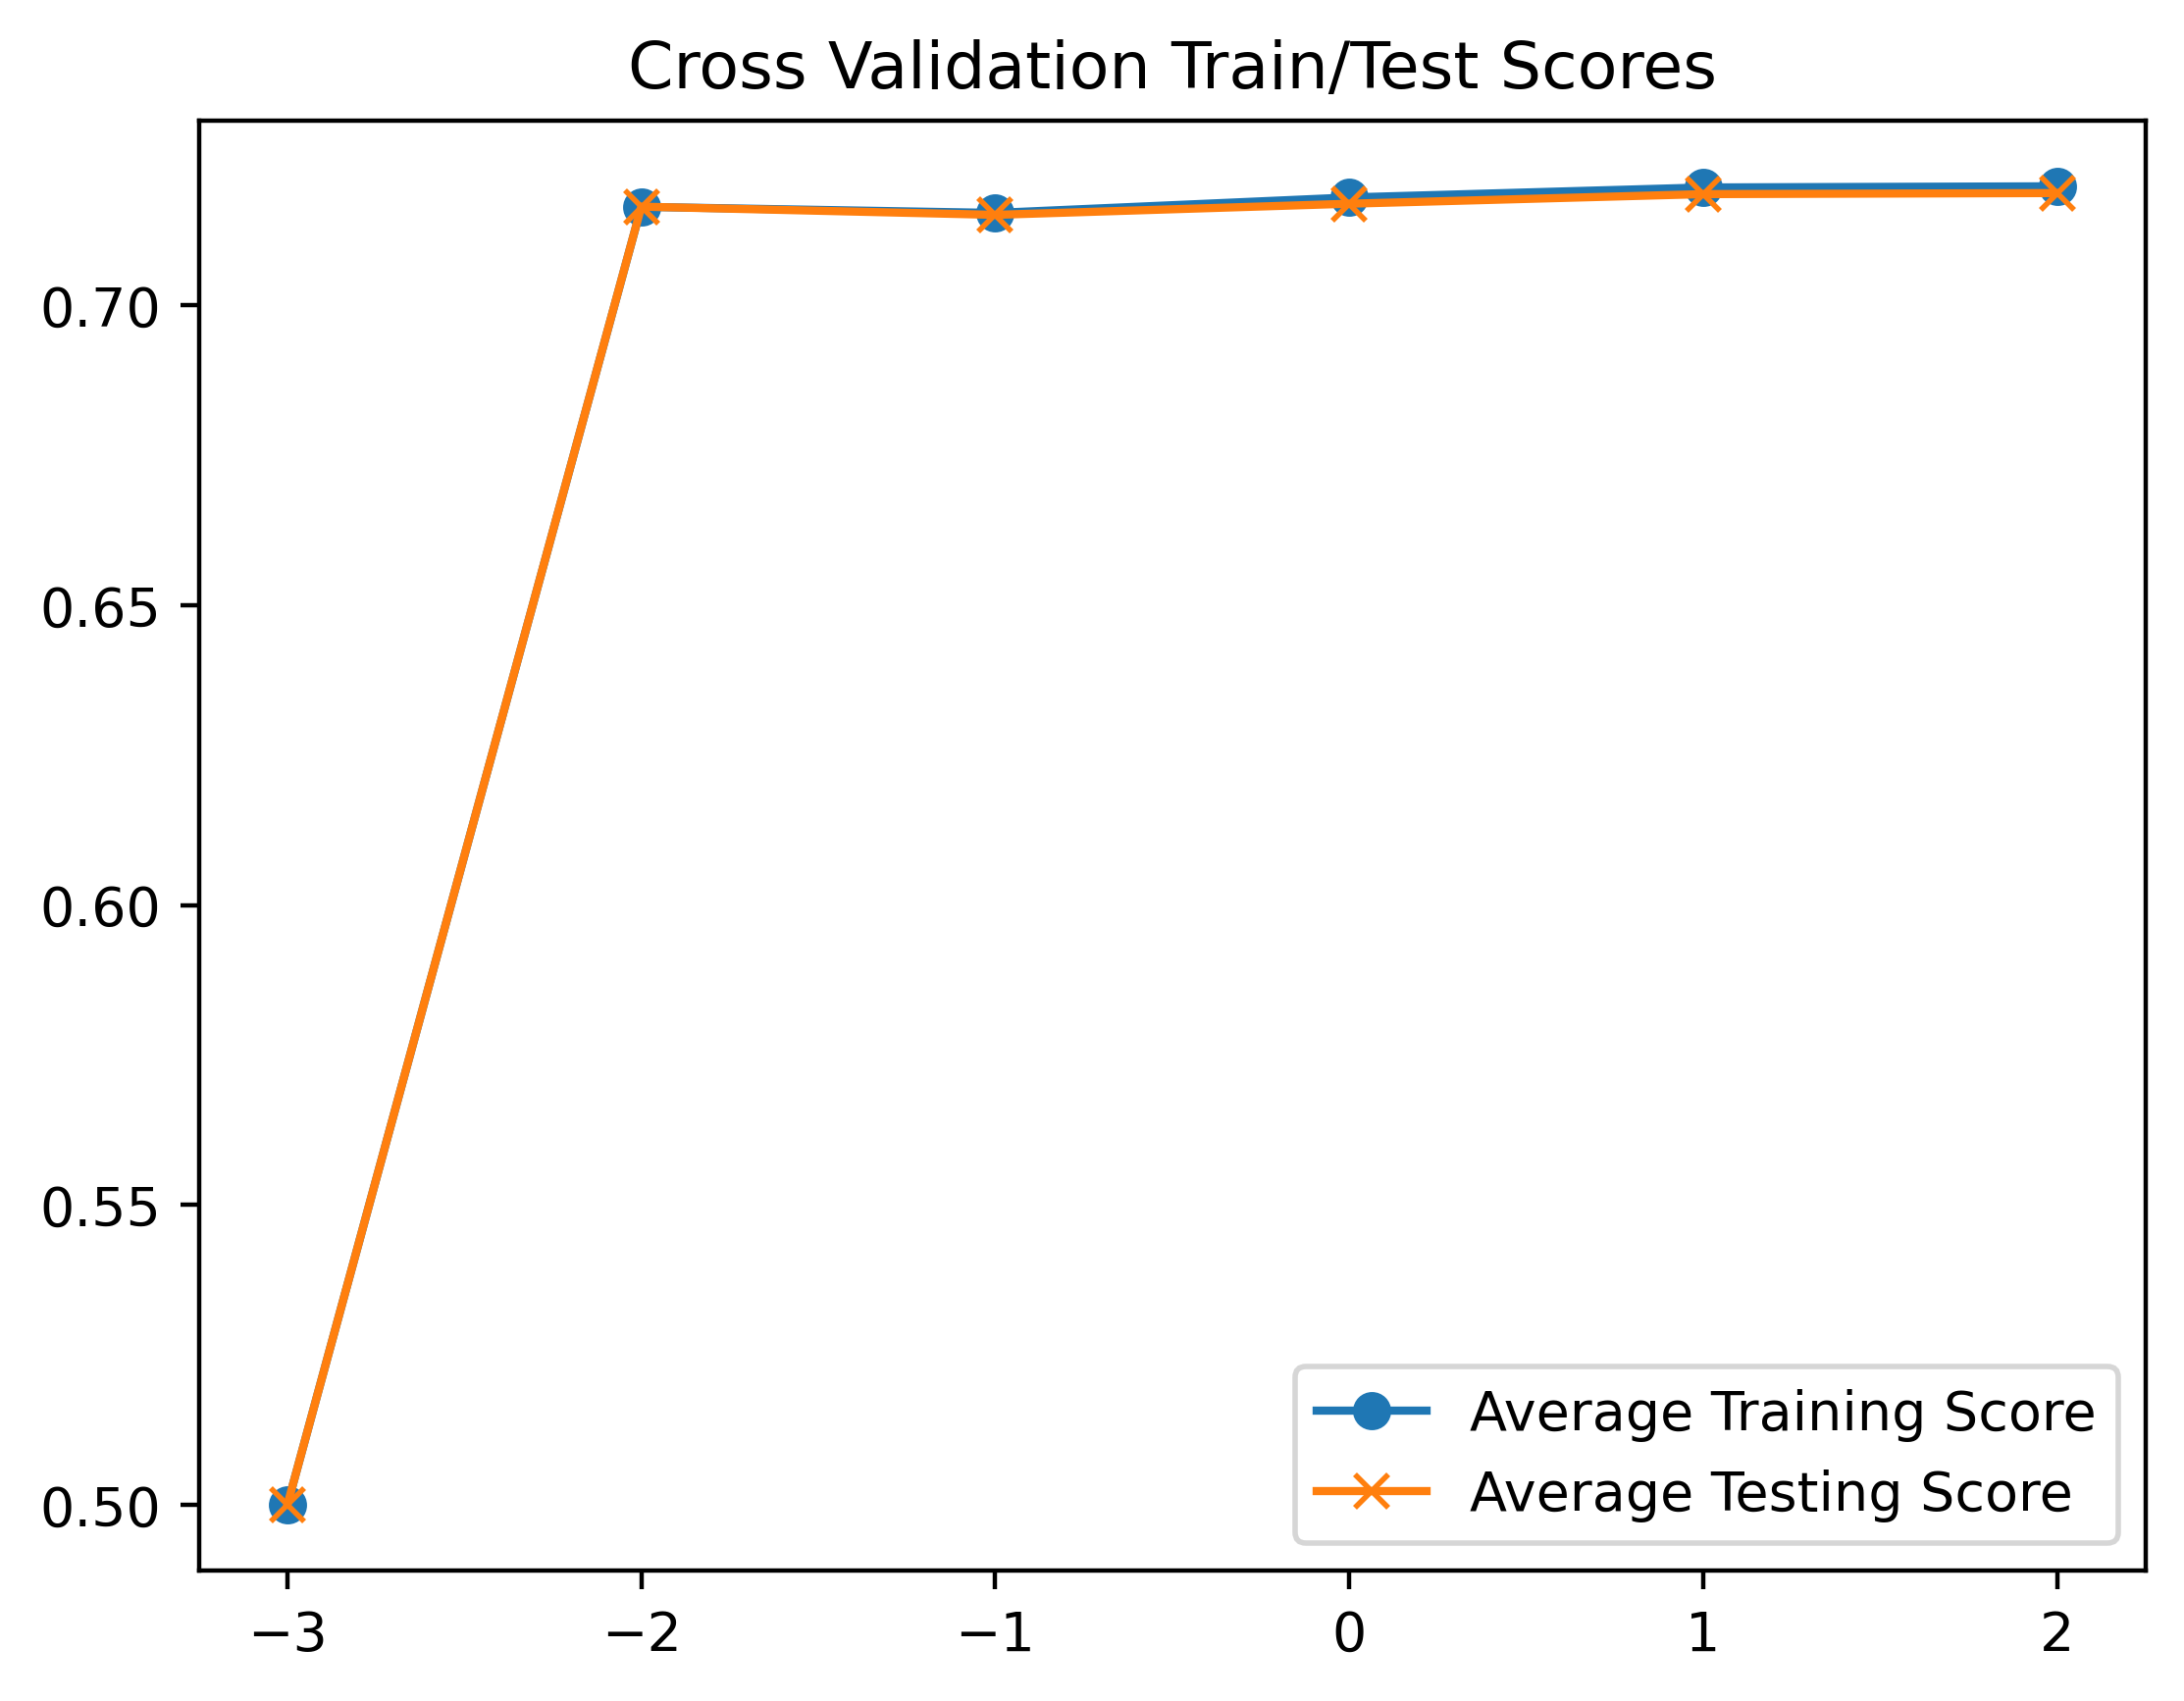

In [145]:
# Plotting CV results for train and test cross validation sets
# Use C value exoinents as x-axis, plotting the average CV performance across all 4 splits in data (average scores by row)
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o', label='Average Training Score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x', label='Average Testing Score')
plt.legend()
plt.title('Cross Validation Train/Test Scores')

In [146]:
# No large discrepancy in cross validation of train and test data; no visible overfitting occurring. Low ROC AUC scores may be a sign of underfitting. 
# As previously mentioned, feature engineering to boost features could enable higher ROC AUC scores and mitigate underfitting

In [147]:
make_interactions = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interact = make_interactions.fit_transform(X)

In [148]:
X_interact.shape

(26664, 153)

In [149]:
X_train, X_test, y_train, y_test = train_test_split(X_interact, df['default payment next month'].values, test_size=0.2, random_state=24)

In [150]:
print('X Train Shape: {} \nX_test.shape: {}'.format(X_train.shape, X_test.shape))
print('y Train Shape: {} \ny_test.shape: {}'.format(y_train.shape, y_test.shape))

X Train Shape: (21331, 153) 
X_test.shape: (5333, 153)
y Train Shape: (21331,) 
y_test.shape: (5333,)


In [151]:
cv_train_roc_auc, cv_test_roc_auc, cv_test_roc = cross_val_C_search_pipe(k_folds=k_folds, C_vals=C_vals, pipeline=scale_lr_pipeline, X=X_train, Y=y_train)

c:\ProgramData\Anaconda\envs\credit_card_default\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda\envs\credit_card_default\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda\envs\credit_card_default\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda\envs\credit_card_default\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C = 100.0


c:\ProgramData\Anaconda\envs\credit_card_default\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda\envs\credit_card_default\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda\envs\credit_card_default\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda\envs\credit_card_default\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C = 10.0


c:\ProgramData\Anaconda\envs\credit_card_default\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda\envs\credit_card_default\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\ProgramData\Anaconda\envs\credit_card_default\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Done with C = 1.0
Done with C = 0.1
Done with C = 0.01
Done with C = 0.001


Text(0.5, 1.0, 'Cross Validation Train/Test Scores')

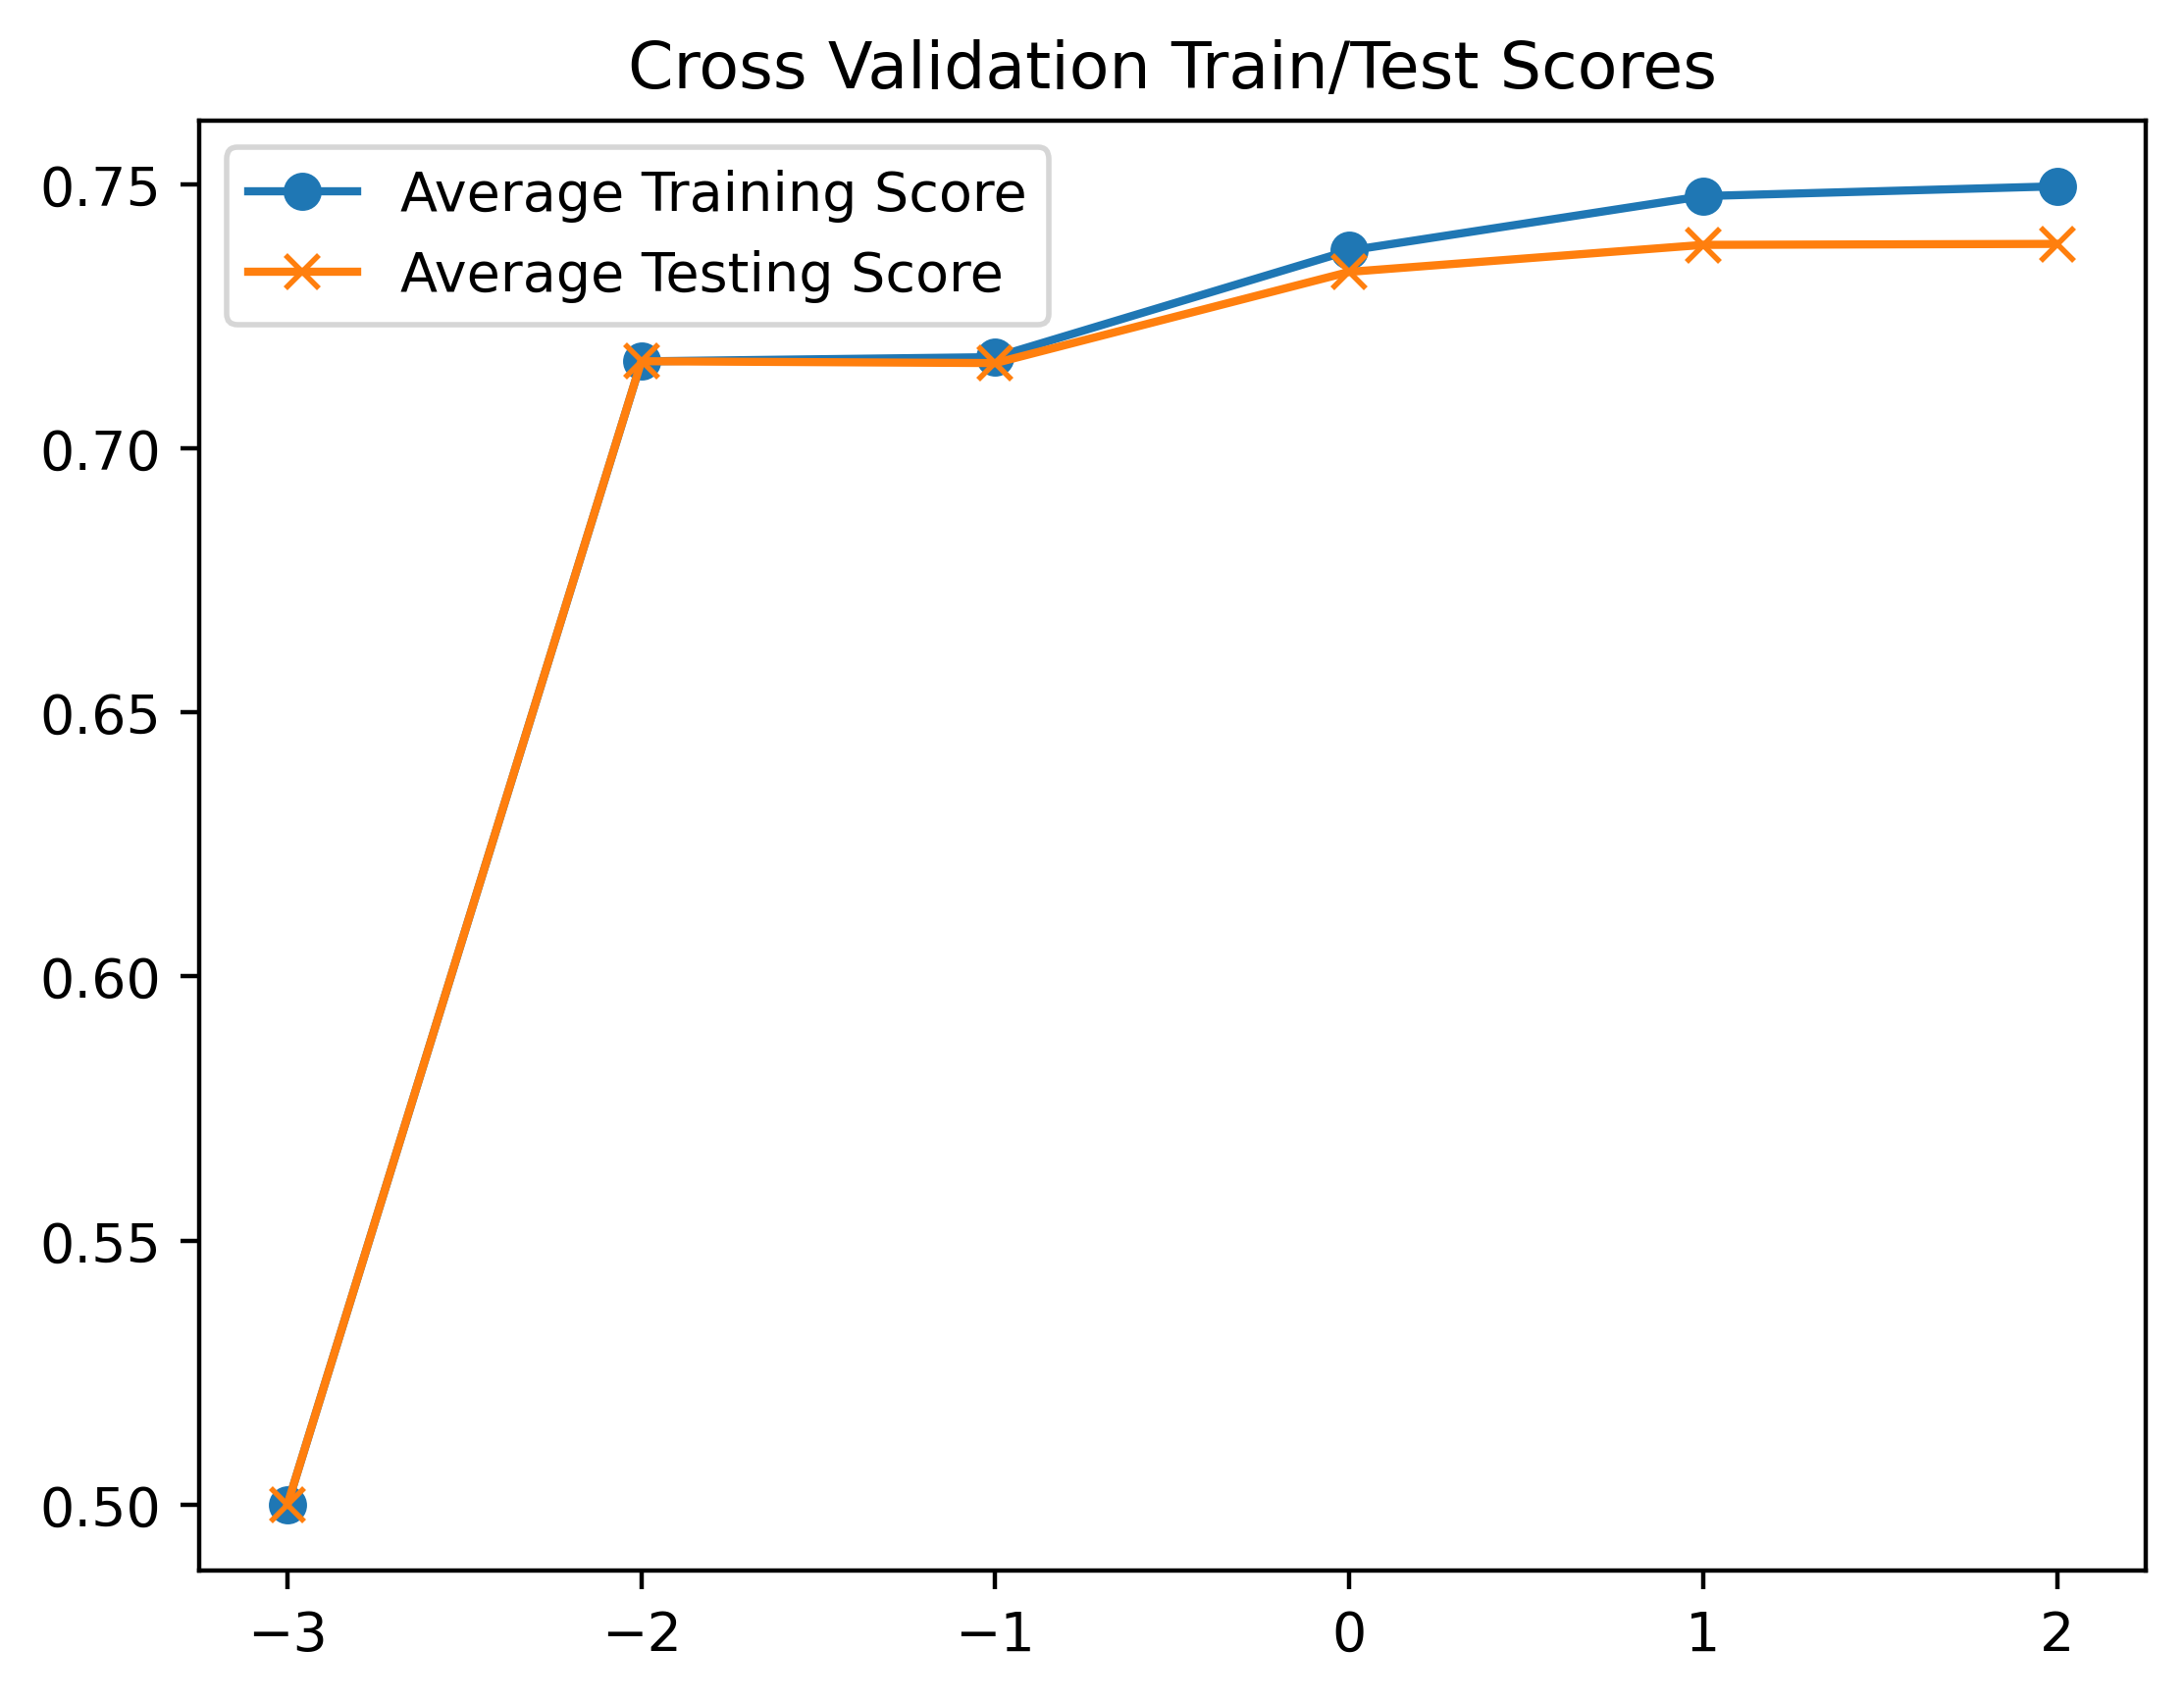

In [154]:
plt.plot(C_val_exponents, np.mean(cv_train_roc_auc, axis=0), '-o', label='Average Training Score')
plt.plot(C_val_exponents, np.mean(cv_test_roc_auc, axis=0), '-x', label='Average Testing Score')
plt.legend()
plt.title('Cross Validation Train/Test Scores')

In [152]:
np.mean(cv_test_roc_auc, axis=0)
# From plot above, 

array([0.73869167, 0.7385066 , 0.73339384, 0.71612807, 0.7164791 ,
       0.5       ])

In [155]:
best_c_val_bool = C_val_exponents == -1 
best_c_val_ix = np.nonzero(best_c_val_bool.astype(int))  # Returns index of c_val_exp=1
best_c_val_ix[0][0]

3

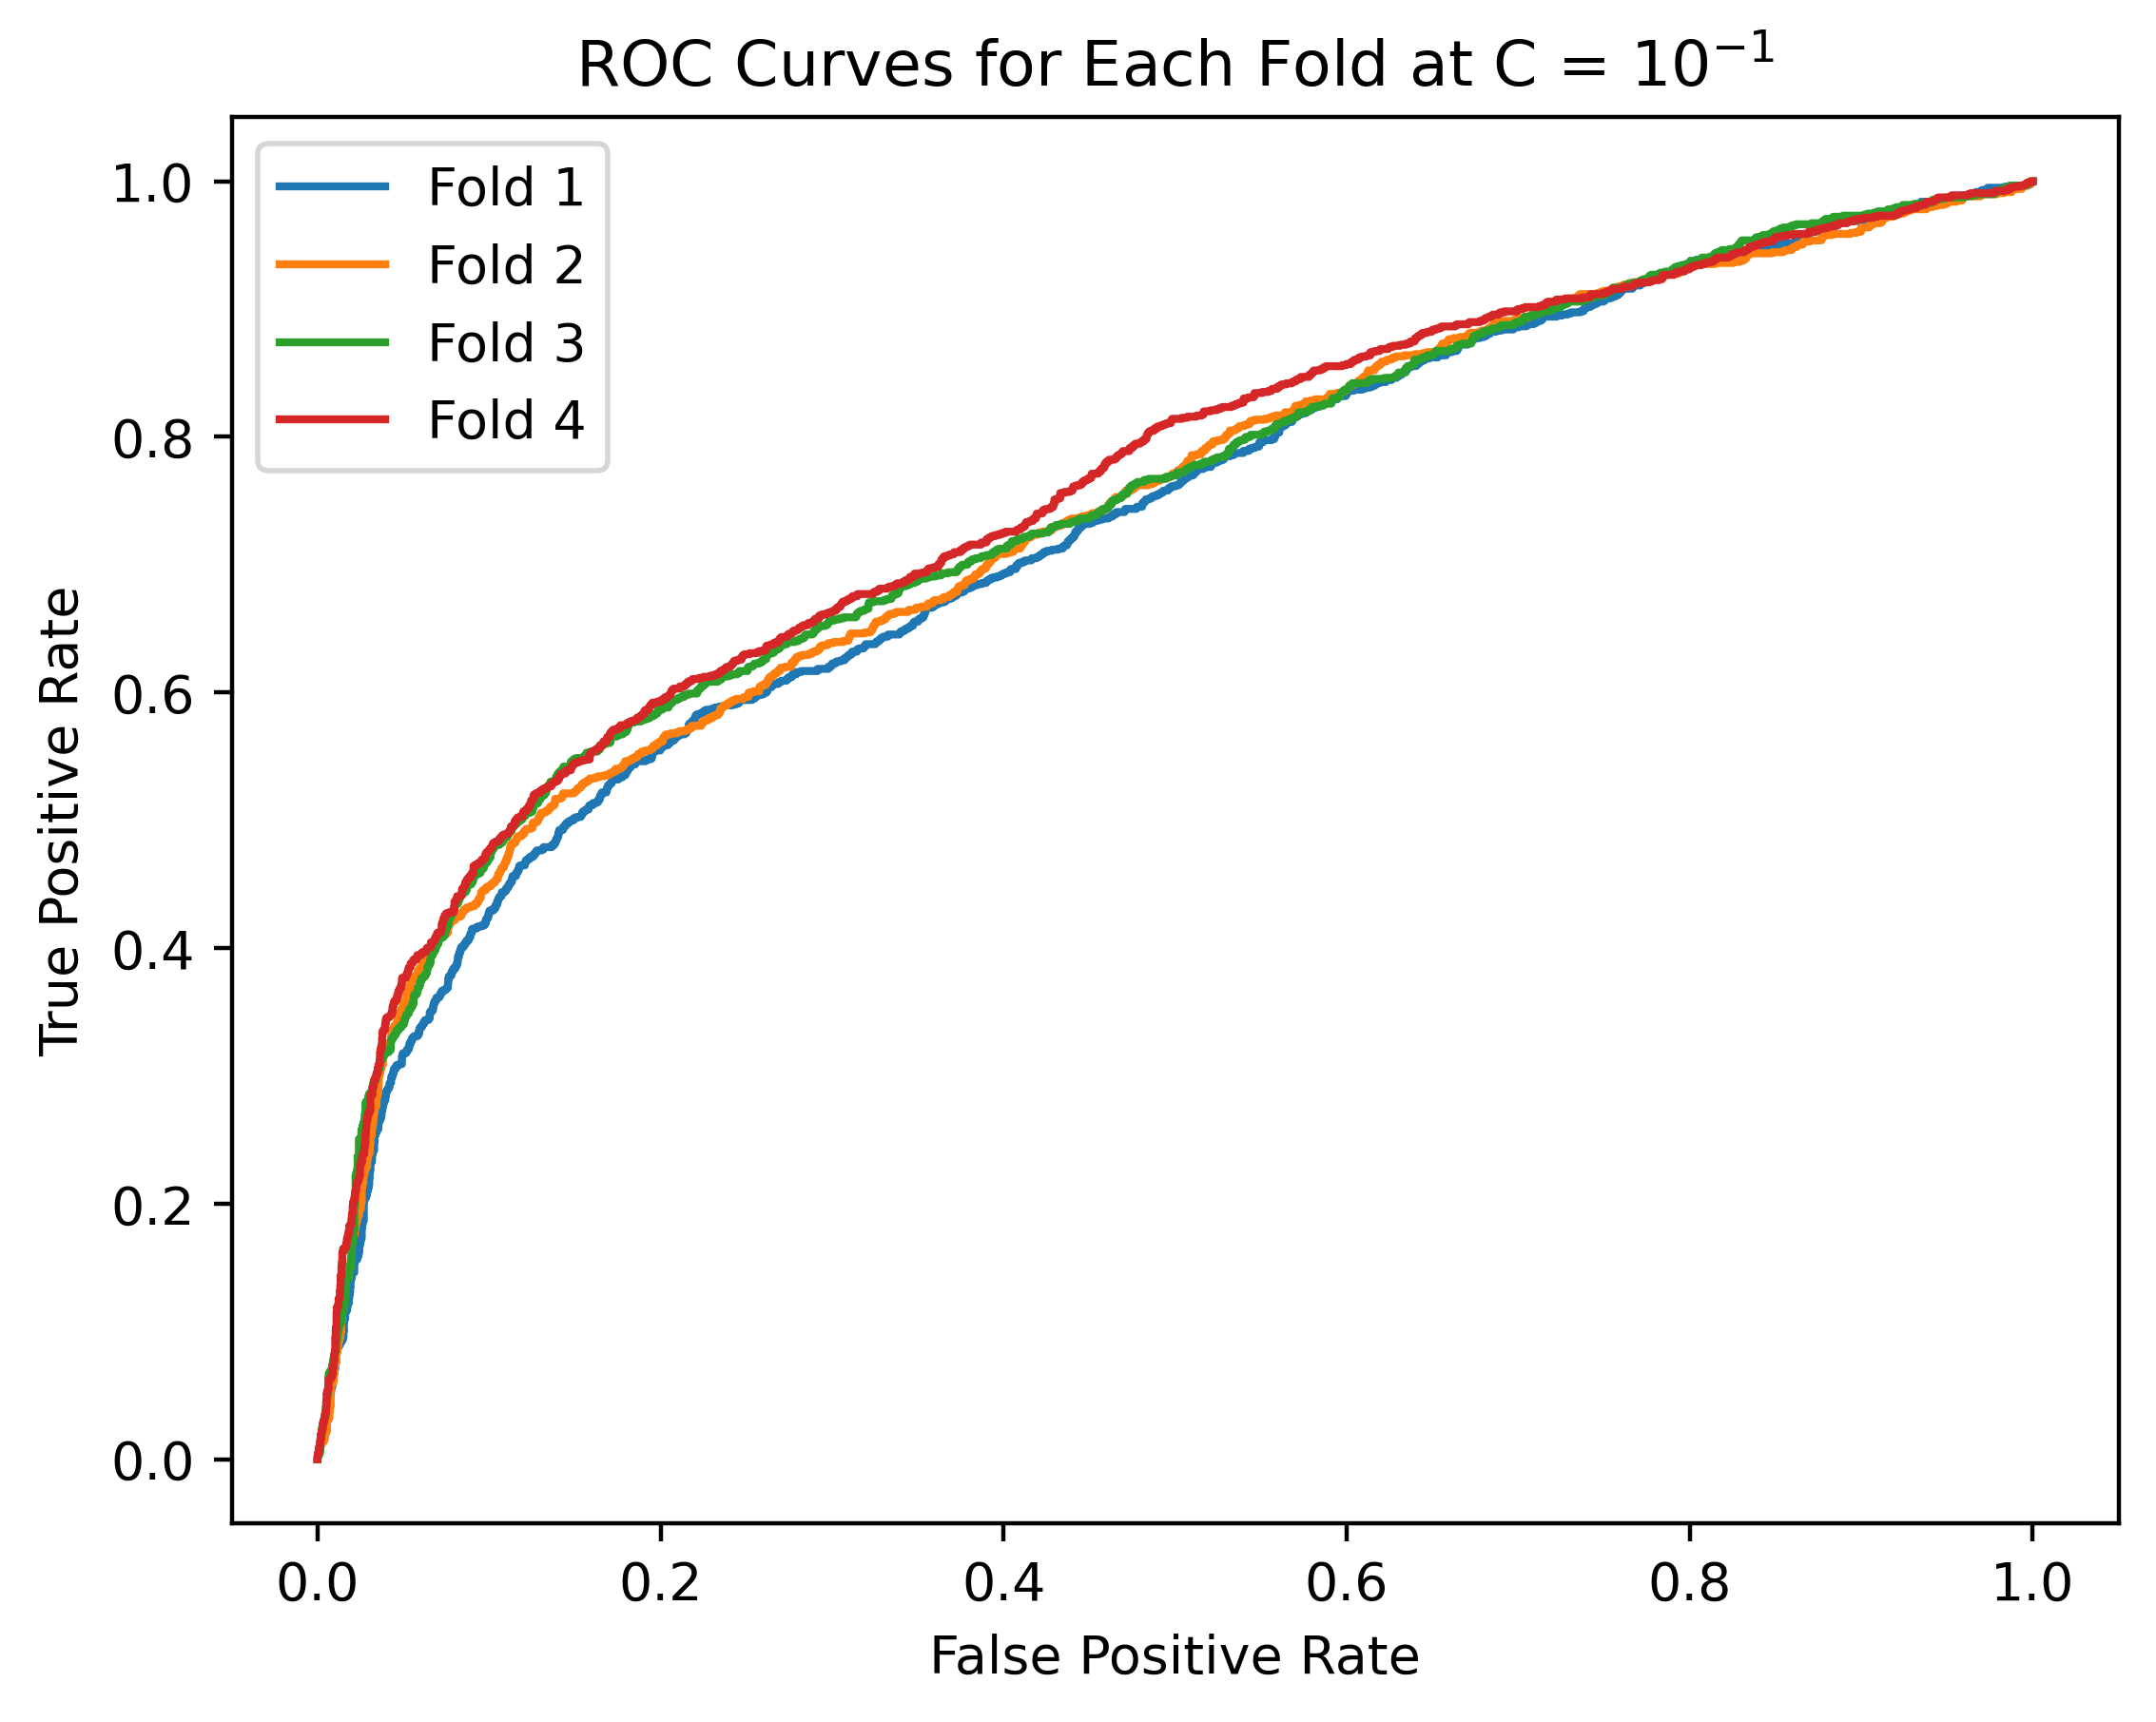

In [158]:
for fold in range(k_folds.n_splits):
    fpr = cv_test_roc[best_c_val_ix[0][0]][fold][0]
    tpr = cv_test_roc[best_c_val_ix[0][0]][fold][1]
    plt.plot(fpr, tpr, label='Fold {}'.format(fold+1))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Fold at C = $10^{-1}$')
plt.legend()
# From plot below, not too much variance between model 
# Normally, with desired FPR, pick a threshold from below.

# Exploration of Other Models - Decision Trees, Random Forest, XGBoost